In [55]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src/silica_opt_insilico/')
from silica_opt_insilico import experiment, execute, data_processing
from saxs_data_processing import target_comparison
    
import numpy as np
import matplotlib.pyplot as plt

import pickle
import matplotlib.animation as animation
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

## Parameters 

### SAXS Data processing parameters

### Experiment 'execution' parameters

In [34]:
# physical experiment bounds

teos_min_vf = 0.005
ammonia_min_vf = 0.005
water_min_vf = 0.005

teos_max_vf = 0.1
ammonia_max_vf = 0.1
water_max_vf = 0.15

noise_frac = 0.5 # what fraction of experimental noise to use

target_r_nm = 40 # particle size target

budget = 100

### Campaign structure 

### 2. Calculate scattering

In [3]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [4]:

target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [5]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

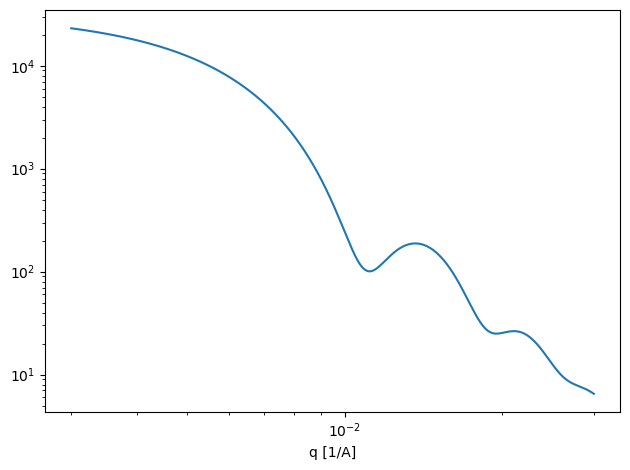

In [6]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')

plt.tight_layout()


In [7]:
trials = {'default':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'Batchsize_1':{
        'batch_size':1,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'Batchsize_10':{
        'batch_size':10,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'AmplitudeWeight_0':{
        'batch_size':5,
        'amplitude_weight':0,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'AmplitudeWeight_0point5':{
        'batch_size':5,
        'amplitude_weight':0.5,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
     'Bounds_restricted':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.6, 0.6, 0.6], 
        'noise_level':0.5
        },
     'NoiseLevel_1':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':1
        },
    'SobolBaseline':{
        'batch_size':0,
        'amplitude_weight':0.1,
        'm_samples':7,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.5
        },
    }

In [8]:
trials_2 = {'as_run_now':{
        'batch_size':10,
        'amplitude_weight':0.5,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':1
        }
           }

In [9]:
for trial_name, params in trials_2.items():
    batch_size = params['batch_size']
    amplitude_weight = params['amplitude_weight']
    m_samples = params['m_samples']
    lower_bounds = params['lower_bounds']
    upper_bounds = params['upper_bounds']
    noise_level = params['noise_level']

    execute.run_grouped_trials(target_I, q_grid, batch_size, amplitude_weight, m_samples, lower_bounds, upper_bounds, trial_name, noise_level, budget)

Running optimization for trial as_run_now
### Replicate 0 ###
starting initial samples


KeyboardInterrupt: 

## 8. Analyze 

#### 1. Convergence plot

In [ ]:
for trial, params in trials_2.items():
    
    batch_size = params['batch_size']
    amplitude_weight = params['amplitude_weight']
    m_samples = params['m_samples']
    lower_bounds = params['lower_bounds']
    upper_bounds = params['upper_bounds']
    noise_level = params['noise_level']

        
    if batch_size == 0:
        n_batches = 0
    else:
        n_batches = int(np.ceil(100/batch_size))

    data_complete = {}
    best_distances_list = []
    best_uuids_list = []
    for i in range(3):
        with open(f'{trial}_replicate_{i}.pkl', 'rb') as f:
            data = pickle.load(f)

        name_bounds = {}
        name_bounds['random'] = (0, 2**m_samples)
        for i in range(n_batches):
            name_bounds[f'Batch {i+1}'] = ((i)*batch_size + 2**m_samples, (i+1)*batch_size + 2**m_samples)

        best_distances_ap = []
        best_uuid = []
        
        for uuid_val, sample in data.items():
            data_complete[uuid_val] = sample
            dist = sample['ap_distance_reporting']
            if len(best_distances_ap) == 0:
                best_distances_ap.append(dist)
                best_distances_ap.append(dist)
                best_uuid.append(uuid_val)
            else:
                best_distances_ap.append(min(best_distances_ap[-1], dist))
        
            
            if dist < best_distances_ap[-2]:
                #print('new min found')
                best_uuid.append(uuid_val)
        best_distances_list.append(best_distances_ap)
        best_uuids_list.append(best_uuid)
        

    ## Convergence plot

    fig, ax = plt.subplots()

    for name, bounds in name_bounds.items():
        ax.fill_between(bounds, 0, max(best_distances_ap), alpha = 0.2)
    #    ax.text(np.mean(bounds), 0.1, name, rotation = 'vertical')

    for best_distances_ap in best_distances_list:
        ax.plot(best_distances_ap)
    
    
    ax.set_xlabel('Sample number')
    ax.set_ylabel('amplitude-phase distance')
    ax.set_title(trial)
    
    plt.tight_layout()
    #plt.savefig('Campaign_convergence_plot.png', dpi = 300)



    # best scatterer plot
    fig, ax = plt.subplots(1,3, figsize = (12,4))

    for i, best_uuid in enumerate(best_uuids_list):

        I = data_complete[best_uuid[-1]]['I_scaled']
    
        ax[i].loglog(q_grid_nonlog, I)
        ax[i].loglog(q_grid_nonlog, target_I, ls ='--')

    fig.suptitle(trial)





    

In [10]:
best_uuids_list[-1]

['34f724e9-9ee6-44a2-b0bf-99006ab5c140',
 'f8ed80f1-131c-4fb9-a5fd-0359574332e9',
 '8e8beb48-cbe2-4470-946c-f87a506ae98b',
 '0e6d77d0-0fcf-41ed-95f5-875141bfcbba',
 'f29a4b1a-d3ce-4137-9d9a-9c2875dc4e4d']

In [11]:
with open('as_run_now_replicate_2.pkl', 'rb') as f:
    data = pickle.load(f)

####  Phase plots

In [12]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def get_colormap_color(value, vmin, vmax, cmap_name='viridis'):
    """
    Maps a scalar value to an RGB color using a specified Matplotlib colormap.
    
    Parameters:
        value (float): The scalar value to be mapped to a color.
        vmin (float): The minimum bound of the scalar range.
        vmax (float): The maximum bound of the scalar range.
        cmap_name (str): The name of the Matplotlib colormap to use (default: 'viridis').
    
    Returns:
        tuple: An (R, G, B) color tuple, where values are in the range [0, 1].
    """
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    return cmap(norm(value))[:3]  # Extract only RGB values (ignoring alpha if present)

In [13]:
x_name = 'TEOS'
y_name = 'water'
y_2_name = 'ammonia'

x_min = 0.005
x_max = 0.1
y_min = 0.005
y_max = 0.15

y_2_min = 0.005
y_2_max = 0.1

bounds = np.array([[x_min, y_min], [x_max, y_max]])
bounds_2 = np.array([[x_min, y_2_min], [x_max, y_2_max]])

/tmp/ipykernel_1551/294263709.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


NameError: name 'pd_utils' is not defined

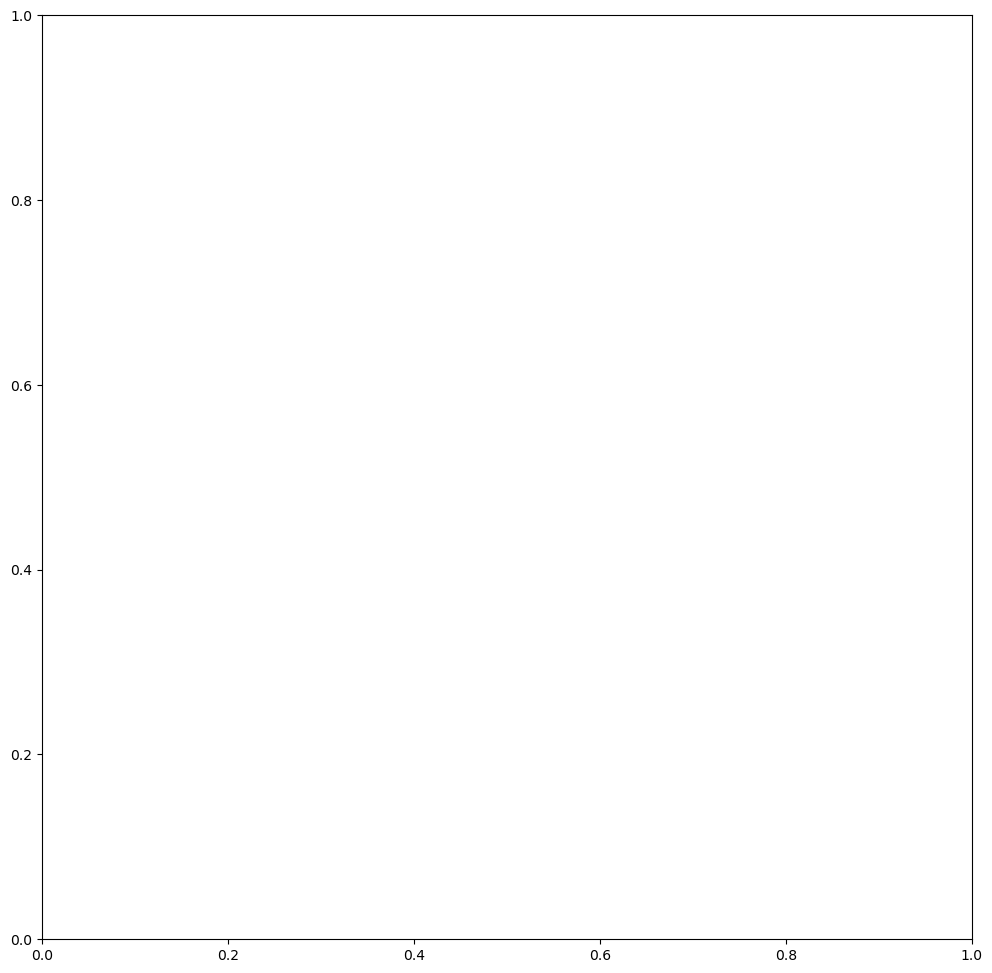

In [14]:
x_key = 'teos_vol_frac'
y_key = 'water_vol_frac'
y_2_key = 'ammonia_vol_frac'


fig, ax = plt.subplots(figsize = (12,12))

c_1 = []
s = []
c_2 = []

colors_1 = []
colors_2 = []
for uuid_val, sample in data.items():

    x_val = sample[x_key]
    y_val = sample[y_key]
    y_2_val = sample[y_2_key]

    
    I = np.log10(sample['scattering_I'])
    

    q = q_grid

    c_1.append([x_val, y_val])
    s.append(I)
    c_2.append([x_val, y_2_val])
    colors_1.append(get_colormap_color(y_2_val, y_2_min, y_2_max))
    colors_2.append(get_colormap_color(y_val, y_min, y_max))

        

s = np.array(s)

pd_utils.plot_phasemap(bounds, ax, c_1, s, colors = colors_1, scale_axis=True)
#pd_utils.plot_phasemap(bounds_2, ax[1], c_2, s, colors = colors_2)


ax.set_xlabel('TEOS volume fraction')
ax.set_ylabel('Water volume fraction')
#ax[1].set_xlabel('TEOS volume fraction')
#ax[1].set_ylabel('Ammonia volume fraction')

cmap_name = 'viridis'
norm = mcolors.Normalize(vmin=y_2_min, vmax=y_2_max)
cmap = cm.get_cmap(cmap_name)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label(y_2_key)


fig.suptitle('Round 2 Optimization Batch 3 - APdist')
#plt.savefig('Phaseplot_apdist_batch3_80nm.png', dpi = 300)

## Plot best scatterer

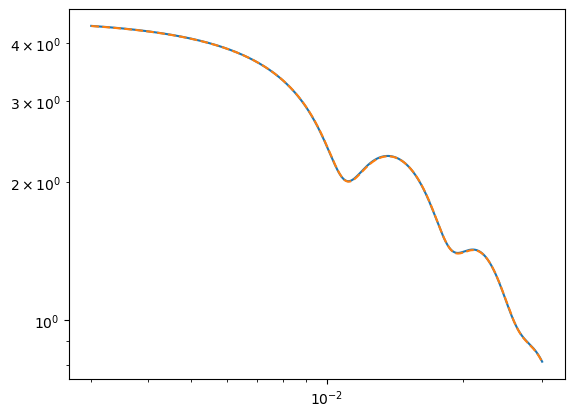

In [16]:
I = data[best_uuid[-1]]['I_scaled']

fig, ax = plt.subplots()

ax.loglog(q_grid_nonlog, I)
ax.loglog(q_grid_nonlog, target_I, ls ='--')

In [17]:
best_uuid

['34f724e9-9ee6-44a2-b0bf-99006ab5c140',
 'f8ed80f1-131c-4fb9-a5fd-0359574332e9',
 '8e8beb48-cbe2-4470-946c-f87a506ae98b',
 '0e6d77d0-0fcf-41ed-95f5-875141bfcbba',
 'f29a4b1a-d3ce-4137-9d9a-9c2875dc4e4d']

## Contour trajectory plot

In [14]:
def contour_eval(teos, ammonia, water, return_scatter = False):

    #teos = sample[0]
    #ammonia = sample[1]
    #water = sample[2]

    noise_level = 0
    amplitude_weight = 0.1
    sample_point = (teos, ammonia, water)
    #print(sample_point)
    scattering, real_sample_point, diameter, pdi = experiment.run_experiment(sample_point, noise_level, q_grid_nonlog, experiment.sld_silica, experiment.sld_etoh)
    #print(diameter)
    # Process measurement
    ap_dist, ap_dist_report, I_scaled = data_processing.process_measurement(scattering, target_I, q_grid, amplitude_weight)

    #print('ap dist ', ap_dist)
    if return_scatter:
        return ap_dist, scattering
    else:
        return ap_dist

In [15]:

n_grid = 50

### 1. Find true minima for this objective function (do once per objective)

In [59]:
#find true min
init = [0.007, 0.018, 0.04]

# Initial guess (x0, y0, z0)
x0 = np.array([init[0], init[1], init[2]])

# Perform minimization using Nelder-Mead method
result = optimize.minimize(contour_eval, x0, method='Nelder-Mead')


(0.007, 0.018, 0.04)
79.56593330170878
ap dist  0.022845644583335312
(0.007350000000000001, 0.018, 0.04)
82.36453711846738
ap dist  0.056664041858280244
(0.007, 0.0189, 0.04)
79.881445133695
ap dist  0.016712331853096434
(0.007, 0.018, 0.042)
80.25425330170877
ap dist  0.02691981814540467
(0.00665, 0.018600000000000002, 0.041333333333333326)
77.29293960420279
ap dist  0.04592225017150885
(0.006825, 0.01845, 0.040999999999999995)
78.6155842566425
ap dist  0.03184655488316808
(0.007175, 0.01815, 0.04033333333333333)
81.14958714770613
ap dist  0.03903193275256327
(0.0069125, 0.018375000000000002, 0.04083333333333333)
79.26264310940752
ap dist  0.021734622390723934
(0.006941666666666666, 0.018850000000000002, 0.03855555555555556)
78.88678644690562
ap dist  0.026372664677488847
(0.006956250000000001, 0.0186375, 0.03941666666666667)
79.22900651233235
ap dist  0.024978639547533356
(0.006985416666666666, 0.0182125, 0.04113888888888889)
79.91273889268221
ap dist  0.025614221000324153
(0.0069635

In [17]:
true_min = [6.936e-03, 2.021e-02, 4.000e-02] # for original 80nm objective

### 2. Calculate contour grid values (once per objective)

In [12]:
import time

In [ ]:
## Build contour plot
n_grid = 50
# Define grid
teos = np.linspace(teos_min_vf, teos_max_vf, n_grid)
ammonia = np.linspace(ammonia_min_vf, ammonia_max_vf, n_grid)

water = 4.000e-02 # set 3rd fixed value to optima
Teos, Ammonia = np.meshgrid(teos, ammonia)
t1 = time.time()
# Compute contour values
Z = np.vectorize(contour_eval)(Teos, Ammonia, water)


with open('TEOS_ammonia_waterOptima_gridvals_80nm_ogfuncs_50.npy', 'wb') as f:
    np.save(f, Z)
print(f'finished grid in {time.time() - t1} s')

In [ ]:
## Build contour plot

# Define grid
teos = np.linspace(teos_min_vf, teos_max_vf, n_grid)
water = np.linspace(water_min_vf, water_max_vf, n_grid)

ammonia = 2.021e-02
Teos, Water = np.meshgrid(teos, water)

# Compute contour values
Z = np.vectorize(contour_eval)(Teos, ammonia, Water)


with open('TEOS_water_ammoniaOptima_gridvals_80nm_ogfuncs_50.npy', 'wb') as f:
    np.save(f, Z)

In [10]:
with open('TEOS_water_ammoniaOptima_gridvals_80nm_ogfuncs_50.npy', 'rb') as f:
    Z_ammonia = np.load(f)

with open('TEOS_ammonia_waterOptima_gridvals_80nm_ogfuncs_50.npy', 'rb') as f:
    Z_water = np.load(f)

In [11]:
trial = 'as_run_now'
replicate = 2

with open(f'{trial}_replicate_{replicate}.pkl', 'rb') as f:
    data = pickle.load(f)

In [12]:
# get best per campaign
i = 0

n_sobol = 2**m_samples
batch_size = 10

best_per_batch = {}


for uuid_val, data_val in data.items():
    data_val['uuid'] = uuid_val
    if i == 0:
        print('initializing current best')
        current_best = data_val

    if current_best is None:
        current_best = data_val

    current_best_ap = current_best['ap_distance']
    new_ap = data_val['ap_distance']
    if new_ap < current_best_ap:
        current_best = data_val
        
    if i == n_sobol -1:
        print('updating sobol best')
        best_per_batch['sobol'] = current_best
        current_best = None

    if (i- (n_sobol - 1)) % batch_size == 0 and i > n_sobol - 1:
        print(i)
        best_per_batch[f'{(i - (n_sobol - 1))/batch_size}'] = current_best
        current_best = None


    i += 1




best_compositions = np.zeros((len(best_per_batch), 3))

for i, (batch, best) in enumerate(best_per_batch.items()):
    comp = [best['teos_vol_frac'], best['ammonia_vol_frac'], best['water_vol_frac']]
    best_compositions[i,:] = comp
    


initializing current best
updating sobol best
41
51
61
71
81
91
101
111
121
131


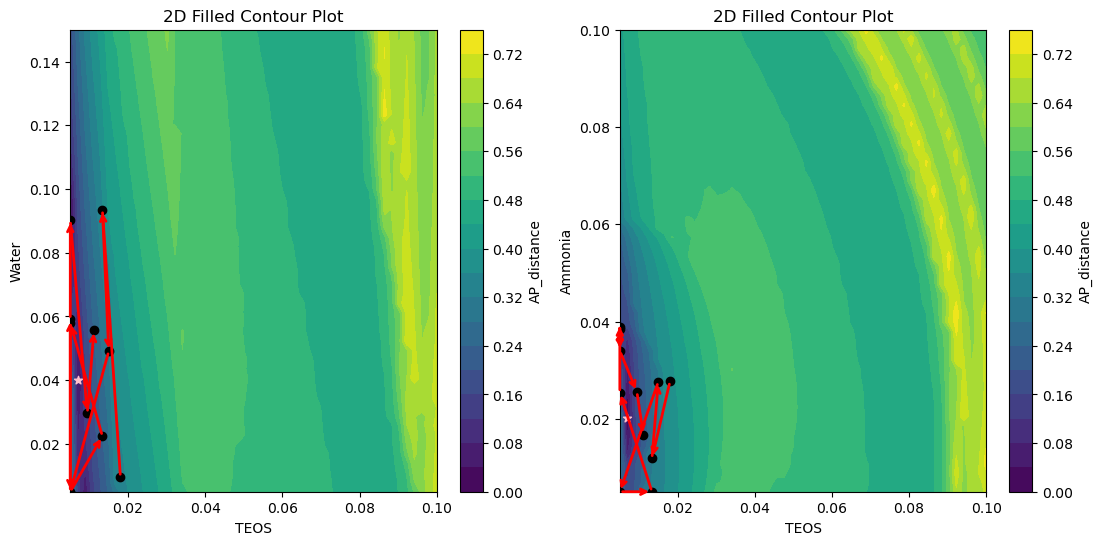

In [18]:


# Create filled contour plot

fig, ax = plt.subplots(1, 2, figsize = (13,6))

ammonia = np.linspace(ammonia_min_vf, ammonia_max_vf, n_grid)
water = np.linspace(water_min_vf, water_max_vf, n_grid)
teos = np.linspace(teos_min_vf, teos_max_vf, n_grid)

                       
contour1 = ax[0].contourf(teos, water, Z_ammonia, levels=20, cmap='viridis')
fig.colorbar(contour1, ax = ax[0], label='AP_distance')
ax[0].set_xlabel('TEOS')
ax[0].set_ylabel('Water')
ax[0].set_title('2D Filled Contour Plot')

ax[0].scatter(best_compositions[:,0], best_compositions[:,2], color = 'k')



# add arrows

for i in range(len(best_compositions) - 1):

    x_start = best_compositions[i, 0]
    y_start = best_compositions[i, 2]
    x_end = best_compositions[i+1, 0]
    y_end = best_compositions[i+1, 2]
    
    ax[0].annotate("", xy=(x_end, y_end), xytext=(x_start, y_start),
             arrowprops=dict(arrowstyle="->", color='red', lw=2))


## TEOS_Ammonia contour
contour2 = ax[1].contourf(teos, ammonia, Z_water, levels=20, cmap='viridis')
fig.colorbar(contour2, ax = ax[1], label='AP_distance')
ax[1].set_xlabel('TEOS')
ax[1].set_ylabel('Ammonia')
ax[1].set_title('2D Filled Contour Plot')

ax[1].scatter(best_compositions[:,0], best_compositions[:,1], color = 'k')

# add arrows

for i in range(len(best_compositions) - 1):

    x_start = best_compositions[i, 0]
    y_start = best_compositions[i, 1]
    x_end = best_compositions[i+1, 0]
    y_end = best_compositions[i+1, 1]
    
    ax[1].annotate("", xy=(x_end, y_end), xytext=(x_start, y_start),
             arrowprops=dict(arrowstyle="->", color='red', lw=2))


ax[0].scatter(true_min[0], true_min[2], marker = '*', color = 'pink')
ax[1].scatter(true_min[0], true_min[1], marker = '*', color = 'pink')

plt.show()

## Animate each point

In [35]:
## Get batches

i = 0

n_sobol = 2**m_samples


batches_points = []

batch = []
for uuid_val, data_val in data.items():
    point = [data_val['teos_vol_frac'], data_val['ammonia_vol_frac'], data_val['water_vol_frac']]
    batch.append(point)
        
    if i == n_sobol -1:
        batches_points.append(batch)
        batch = []

    if (i- (n_sobol - 1)) % batch_size == 0 and i > n_sobol - 1:
        batches_points.append(batch)
        batch = []


    i += 1

In [37]:
n_batches = int(budget/batch_size)

batch_nums = [str(i+1) for i in range(n_batches)]
batch_names = ['Sobol random']

batch_names.extend(batch_nums)

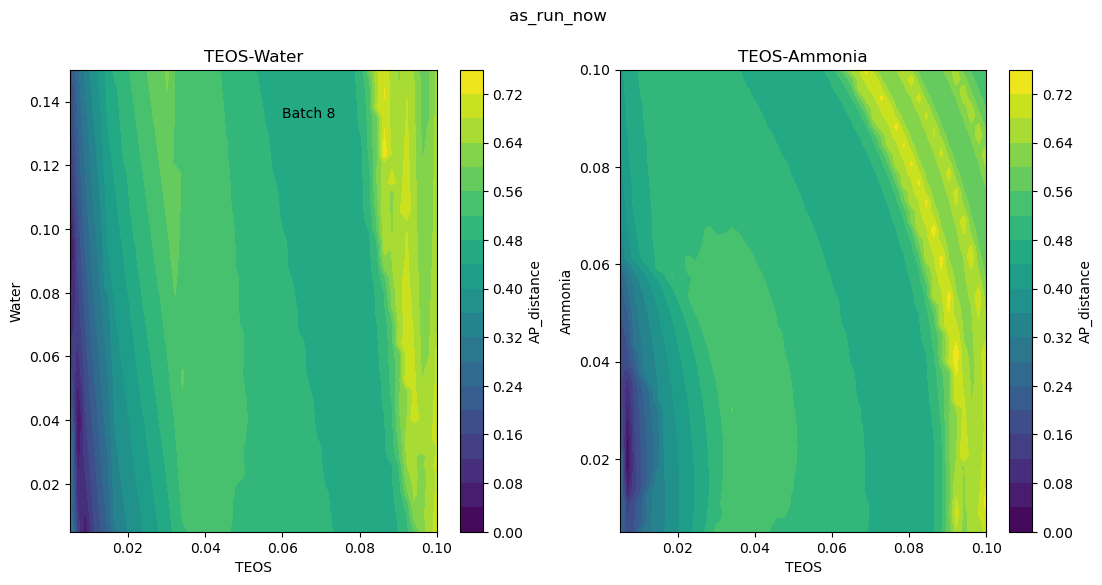

In [91]:
# Create filled contour plot

fig, ax = plt.subplots(1, 2, figsize = (13,6))
#fig, ax = plt.subplots()
num_frames = n_batches

ammonia = np.linspace(ammonia_min_vf, ammonia_max_vf, n_grid)
water = np.linspace(water_min_vf, water_max_vf, n_grid)
teos = np.linspace(teos_min_vf, teos_max_vf, n_grid)

contour1 = ax[0].contourf(teos, water, Z_ammonia, levels=20, cmap='viridis')
fig.colorbar(contour1, ax = ax[0], label='AP_distance')
ax[0].set_xlabel('TEOS')
ax[0].set_ylabel('Water')
ax[0].set_title('TEOS-Water')

contour2 = ax[1].contourf(teos, ammonia, Z_water, levels=20, cmap='viridis')
fig.colorbar(contour2, ax = ax[1], label='AP_distance')
ax[1].set_xlabel('TEOS')
ax[1].set_ylabel('Ammonia')
ax[1].set_title('TEOS-Ammonia')


fig.suptitle(trial_name)

def get_alpha(i, frame):
    if frame - i >= 5:
        return 0.1
    if frame - i - 1 == 0:
        return 1
    else:
        return 0.2*(frame - i)

text = ax[0].text(0.06, 0.135, '')

scatter_plots = []
def update(frame):
    """Update function for animation."""

    global scatter_plots

    for sc in scatter_plots:
        try:
            sc.remove()
        except:
            continue
    
    for i in range(frame):
        text.set_text('Batch ' + batch_names[i])
        alpha = get_alpha(i, frame)
        current_batch = batches_points[i]
        if frame - i - 1 == 0:
            color = 'red'
        else:
            color = 'k'
        for point in current_batch:
            sc1 = ax[0].scatter(point[0], point[2], color = color, alpha = alpha)
            sc2 = ax[1].scatter(point[0], point[1], color = color, alpha = alpha)

            scatter_plots.append(sc1)
            scatter_plots.append(sc2)
        

    return scatter_plots + [text]


ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=800, blit=False)
#plt.show()

html_ani = ani.to_jshtml()
HTML(html_ani)

with open('testhtml.html', 'wt') as f:
    f.write(html_ani)